In [1]:
#from pprint import pprint   # only for this example
import matplotlib.pyplot as plt
from agilent_ir_file import AgilentIRFile
import library_OS_fit as lib_OS
import spec_process as spec_p
import numpy as np
import agilent_to_python as a2p
from scipy import stats
import pandas as pd
from collections import Counter

In [2]:
filename = r'C:\Users\Shreyas.Patankar\Ocean Wise Conservation Association\Plastics Lab Team - General\00_FTIR_Data\mosaic_test_and_results\m3\m3.dmt'

reader = AgilentIRFile()
reader.read(filename)

xvalues = reader.wavenumbers
intensities = reader.intensities
metadata = reader.metadata

print(xvalues)
print(intensities.shape)
#pprint(metadata)

[ 898.66574955  900.59421682  902.5226841  ... 3797.15206194 3799.08052921
 3801.00899649]
(256, 192, 1506)


In [3]:

#data = reader.read(filename)
#data
intensities = a2p.hsi_df(reader)
wavenumbers = a2p.data_wns(reader)

md = reader.metadata


In [4]:
library_wavenos = lib_OS.get_lib_wns()

smoothing_order = 1
smoothing_window = 5


library_wavenos
proc = spec_p.proc(intensities[-219,154,:],smoothing_window, smoothing_order,wavenumbers,library_wavenos)
#plt.plot(library_wavenos,proc)

clust_der_values = pd.read_csv('OS_clusters_DERINT.csv')

def norm_pearson(p,q):
    modp = p/(np.max(p) - np.min(p))
    modq = q/(np.max(q) - np.min(q))
    return stats.pearsonr(modp,modq)[0]


def pearson_rs(p):
    def normp_pearson(q):
        return norm_pearson(p,q)
    return np.apply_along_axis(normp_pearson,axis=0,arr=clust_der_values)

np.argmax(pearson_rs(proc))
#pearson_rs(proc)
#lib_OS.libOS_fit_1(proc)

4

In [5]:

def bPR(p):
    proc = spec_p.proc(p,smoothing_window, smoothing_order,wavenumbers,library_wavenos)
    prsc = pearson_rs(proc)
    ix = np.argmax(prsc)
    if prsc[ix] > 0.3:
        return (ix , prsc[ix])
    else: return (0 , ix)

bPR(intensities[-229,154,:])
lib_OS.libOS_fit_1(proc).iloc[0,2:4].values
#vals = np.apply_along_axis(bPR,2,intensities)

np.max(reader.total_image)

llim = 400

#plt.imshow(np.where(reader.total_image > llim,1,0))
np.sum(np.where(reader.total_image > llim,1,0))
print(list(np.argwhere(reader.total_image > llim)))
ll = [tuple(k) for k in np.argwhere(reader.total_image > llim)]
#Counter([bPR(intensities[k]) for k in ll])


[array([ 19, 130], dtype=int64), array([ 19, 131], dtype=int64), array([ 19, 132], dtype=int64), array([ 19, 133], dtype=int64), array([ 19, 134], dtype=int64), array([ 19, 135], dtype=int64), array([ 19, 136], dtype=int64), array([ 19, 137], dtype=int64), array([ 19, 138], dtype=int64), array([ 19, 139], dtype=int64), array([ 20, 131], dtype=int64), array([ 20, 132], dtype=int64), array([ 20, 133], dtype=int64), array([ 20, 134], dtype=int64), array([ 20, 135], dtype=int64), array([ 20, 136], dtype=int64), array([ 20, 137], dtype=int64), array([ 20, 138], dtype=int64), array([ 20, 139], dtype=int64), array([ 20, 140], dtype=int64), array([ 20, 141], dtype=int64), array([ 20, 142], dtype=int64), array([ 20, 143], dtype=int64), array([ 21, 132], dtype=int64), array([ 21, 133], dtype=int64), array([ 21, 134], dtype=int64), array([ 21, 135], dtype=int64), array([ 21, 136], dtype=int64), array([ 21, 137], dtype=int64), array([ 21, 138], dtype=int64), array([ 21, 139], dtype=int64), array([

In [6]:
from scipy.signal import savgol_filter as sgf

def deriv(p, w):
    deriv_a = np.array(p) - np.roll(p,w)
    deriv_a[:w] = deriv_a[w]
    return deriv_a

def smoother(p, smoothing_window, smoothing_order):

        return np.array(sgf(p,smoothing_window,smoothing_order))

def bgF(p):
    return np.array(p)-np.array(smoother(p,1001,2))


In [7]:
rows = [k[0] for k in ll]
cols = [k[1] for k in ll]
idmap = np.zeros_like(reader.total_image)

idmap[rows,cols] = [bPR(intensities[k])[0] for k in ll]


Text(0.06, 0.455, 'position ($\\mu$m)')

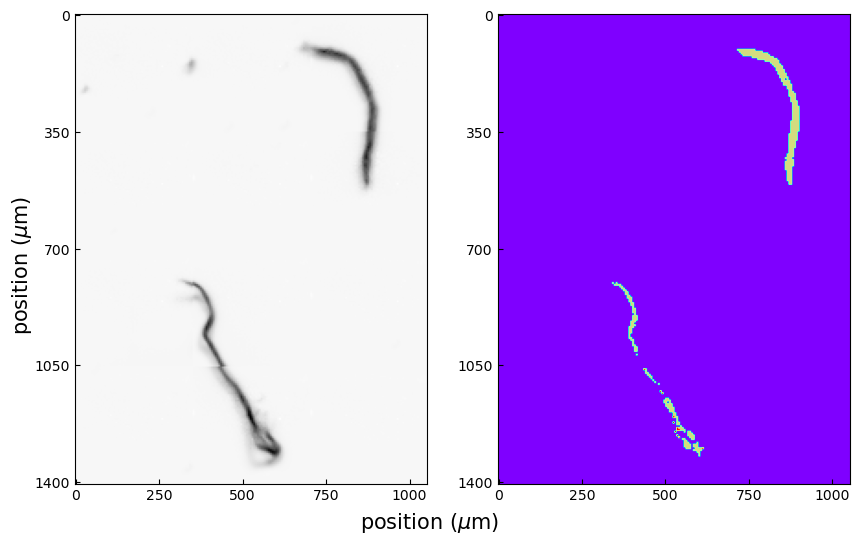

In [8]:
xtick = int(md['xpixels']*5.5/4/50)/5.5*50
ytick = int(md['ypixels']*5.5/4/50)/5.5*50

fig, axs = plt.subplots(1,2,figsize = (10,20))
axs[0].imshow(reader.total_image, cmap = 'Greys')
axs[1].imshow(idmap, cmap = 'rainbow')
for ax in axs:
    ax.set_xticks(np.arange(5)*xtick)
    ax.set_yticks(np.arange(5)*ytick)
    ax.set_xticklabels(['{0:.6g}'.format(k) for k in np.arange(5)*xtick*5.5])
    ax.set_yticklabels(['{0:.6g}'.format(k) for k in np.arange(5)*ytick*5.5])
    ax.tick_params(direction='in')

fig.text(.41,.355,'position ($\mu$m)', fontsize = 15)
fig.text(.06,.455,'position ($\mu$m)', fontsize = 15, rotation = 90)

#xtick

,label,area,axis_major_length,axis_minor_length,appr_len,appr_wid
0,1,512.0,95.733207,25.379211,660.122447,3.163303
1,2,6.0,3.265986,2.000000,8.117636,2.599586
2,3,562.0,125.122444,12.556469,719.808469,3.543471
3,4,1.0,0.000000,0.000000,1.414214,1.000000


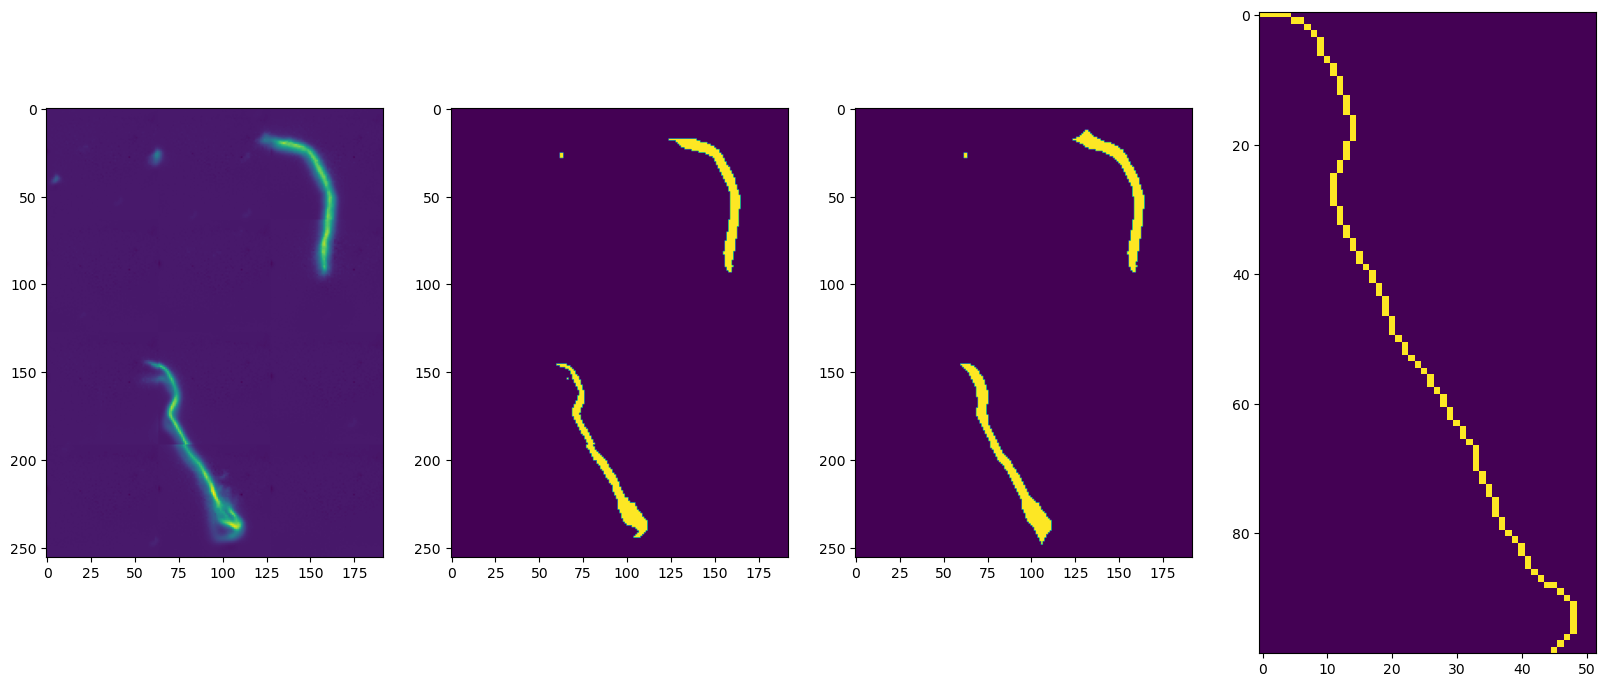

In [34]:
#from skimage import morphology, measure

from skimage.morphology import disk, closing, medial_axis, skeletonize
from skimage.measure import label, regionprops, regionprops_table

im = reader.total_image
mask = im > 500*im.mean()
clsd = closing(mask,disk(20))
fig, axs = plt.subplots(1,4,figsize=(20,15))
axs[0].imshow(im)
axs[1].imshow(mask)
axs[2].imshow(clsd)


lbls, ns = label(mask, return_num = True)
props = regionprops(lbls)

#len(props)
axs[3].imshow(skeletonize(props[2].image))
#props[3].orientation

def appr_len(region):
    q = np.arctan(np.shape(region)[0]/np.shape(region)[1])
    return (np.sum(region))*((np.sqrt(2)-1)*(np.sin(2*q)**2)+1)

def appr_wid(region):
    skel, distance = medial_axis(region, return_distance=True)
    return np.mean([k for k in distance.flatten() if k >= np.max(distance.flatten())/2])

pd.DataFrame(regionprops_table(lbls, properties = ['label','area','axis_major_length', 'axis_minor_length'], extra_properties = (appr_len,appr_wid,)))

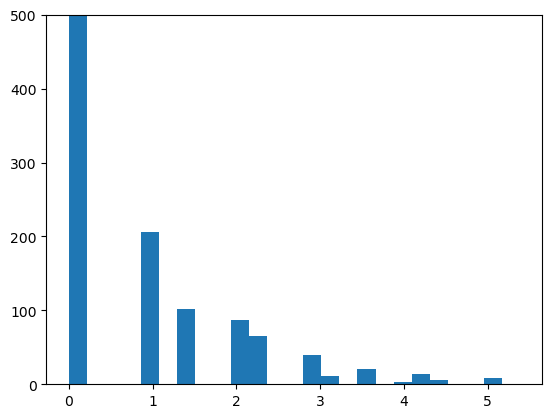

3.5434708757866513

In [31]:
skel, distance = medial_axis(props[2].image, return_distance=True)
#plt.imshow(distance)

plt.hist(distance.flatten(), bins=25)
plt.ylim([0,500])
plt.show()
np.mean([k for k in distance.flatten() if k >= np.max(distance.flatten())/2])


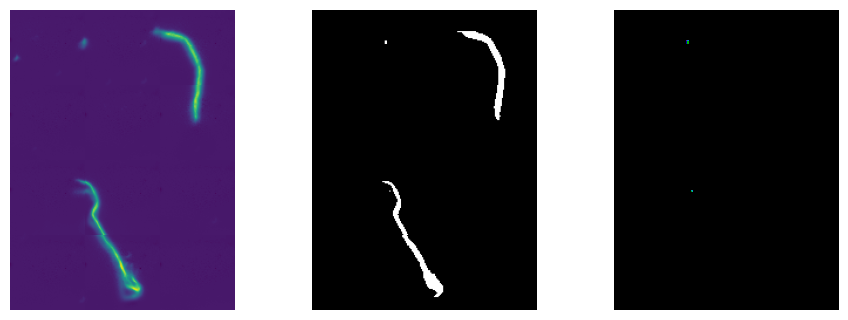

In [ ]:

mask = im > 500*im.mean()

from scipy import ndimage

label_im, nb_labels = ndimage.label(mask)



sizes = ndimage.sum(mask, label_im, range(nb_labels + 1))

plt.figure(figsize=(9,3))

plt.subplot(131)
plt.imshow(im)
plt.axis('off')
plt.subplot(132)
plt.imshow(mask, cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(133)
mask_size = sizes > 500
remove_pixel = mask_size[label_im]
remove_pixel.shape

label_im[remove_pixel] = 0
plt.imshow(label_im, cmap=plt.cm.nipy_spectral)
plt.axis('off')

plt.subplots_adjust(wspace=0.02, hspace=0.02, top=1, bottom=0, left=0, right=1)
plt.show()

In [ ]:
np.arctan(np.shape(props[2].image)[1]/np.shape(props[2].image)[0])

0.4836449429739567

In [ ]:
import time
p = intensities[-219,154,:]
start = time.time()
pearson_rs(proc)
end = time.time()

print('eval time single pearson = ', end - start)


eval time single pearson =  0.04090452194213867


In [ ]:
()()%%??

def bPR0(p):
    proc = spec_p.proc(p,smoothing_window, smoothing_order,wavenumbers,library_wavenos)
    prsc = pearson_rs(proc)
    ix = np.argmax(prsc)
    if prsc[ix] > 0.3:
        return ix 
    else: return 0

start = time.time()
idmap[rows,cols] = [bPR0(intensities[k]) for k in ll]
end = time.time()

print('eval time bPR implement = ', end - start)



SyntaxError: invalid syntax (320347626.py, line 1)

In [ ]:

from multiprocessing import Pool

pool = Pool(processes=6)

start = time.time()
maplist = pool.map(bPR0,[intensities[k] for k in ll])
idmap[rows,cols] = list(maplist)
end = time.time()

print('eval time bPR map multicore= ', end - start)


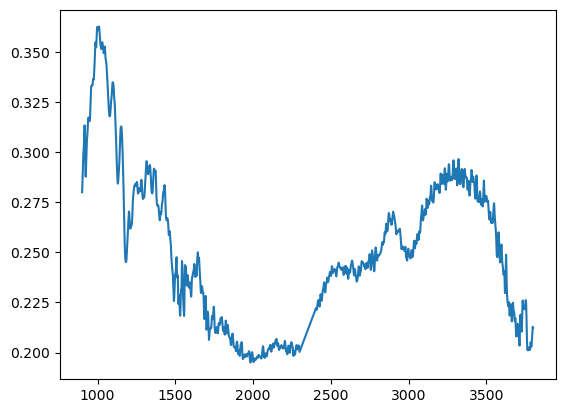

In [ ]:
plt.plot(wavenumbers,intensities[-219,154,:])